In [1]:
import gc
gc.collect()

0

In [1]:
import pandas as pd

In [4]:
df=pd.read_csv("kidsInMindSubtitles2004 (2).csv")
df.shape

(2004, 15)

In [4]:
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
model_name = "facebook/bart-large-cnn"  
class BartForRegression(torch.nn.Module):
    def __init__(self):
        super(BartForRegression, self).__init__()
        self.bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
        self.dropout = torch.nn.Dropout(0.1)
        self.regression_head = torch.nn.Linear(self.bart_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bart_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        hidden_state = outputs.decoder_hidden_states[-1]
        regression_output = self.regression_head(self.dropout(hidden_state[:, 0]))

        return regression_output.squeeze(-1)

In [6]:
class SubtitlesDataset(Dataset):
    def __init__(self, texts, labels_regression, tokenizer, max_length):
        self.texts = texts
        self.labels_regression = labels_regression
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label_regression = float(self.labels_regression[idx])

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return input_ids, attention_mask, label_regression

In [8]:
texts = df['subtitles'].tolist()
labels_regression = df['Language'].tolist()

In [9]:
train_texts, val_texts, train_labels_regression, val_labels_regression = train_test_split(texts, labels_regression, test_size=0.1, random_state=42)

In [7]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForRegression()

In [11]:
train_dataset = SubtitlesDataset(train_texts, train_labels_regression, tokenizer, max_length=128)
val_dataset = SubtitlesDataset(val_texts, val_labels_regression, tokenizer, max_length=128)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [13]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=2.2908675418875646e-06)
num_epochs = 15
train_losses = []
val_losses = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels_regression = batch
        optimizer.zero_grad()

        regression_output = model(input_ids=input_ids, attention_mask=attention_mask)
        labels_regression = labels_regression.float()
        regression_output = regression_output.squeeze(-1)
        loss = torch.nn.functional.mse_loss(regression_output, labels_regression)
        print(loss)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels_regression = batch
            regression_output = model(input_ids=input_ids, attention_mask=attention_mask)
            regression_output = regression_output.squeeze(-1)
            val_loss = torch.nn.functional.mse_loss(regression_output, labels_regression)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
#     print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")


tensor(35.2033, grad_fn=<MseLossBackward0>)
tensor(35.1059, grad_fn=<MseLossBackward0>)
tensor(27.3035, grad_fn=<MseLossBackward0>)
tensor(26.9465, grad_fn=<MseLossBackward0>)
tensor(30.7320, grad_fn=<MseLossBackward0>)
tensor(22.5247, grad_fn=<MseLossBackward0>)
tensor(32.1578, grad_fn=<MseLossBackward0>)
tensor(29.5099, grad_fn=<MseLossBackward0>)
tensor(25.9635, grad_fn=<MseLossBackward0>)
tensor(14.1398, grad_fn=<MseLossBackward0>)
tensor(23.1998, grad_fn=<MseLossBackward0>)
tensor(21.7848, grad_fn=<MseLossBackward0>)
tensor(20.1854, grad_fn=<MseLossBackward0>)
tensor(13.4324, grad_fn=<MseLossBackward0>)
tensor(16.4642, grad_fn=<MseLossBackward0>)
tensor(12.8907, grad_fn=<MseLossBackward0>)
tensor(14.5080, grad_fn=<MseLossBackward0>)
tensor(6.1321, grad_fn=<MseLossBackward0>)
tensor(11.3681, grad_fn=<MseLossBackward0>)
tensor(8.6055, grad_fn=<MseLossBackward0>)
tensor(10.8660, grad_fn=<MseLossBackward0>)
tensor(4.0470, grad_fn=<MseLossBackward0>)
tensor(6.6070, grad_fn=<MseLossBack

In [20]:
data = {'Epoch': range(1, num_epochs + 1),
        'Train Loss': train_losses,
        'Validation Loss': val_losses}

In [19]:
len(val_losses)

15

In [21]:
df2 = pd.DataFrame(data)
excel_filename = "losses_per_epoch2.xlsx"
df2.to_excel(excel_filename, index=False)
print("Train and Validation Losses per Epoch saved to:", excel_filename)

Train and Validation Losses per Epoch saved to: losses_per_epoch2.xlsx


In [22]:
torch.save(model.state_dict(), 'models/BartForRegression.pth')

In [ ]:
model = BartForRegression()

In [ ]:
model.load_state_dict(torch.load('models/BartForRegression.pth'))

In [9]:
test_text = df['subtitles'][1700]

In [10]:
inputs = tokenizer(test_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

# Get input_ids and attention_mask from the tokenizer output
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

In [11]:
model.eval()

with torch.no_grad():
    regression_output = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)

predicted_score = regression_output.item()

In [12]:
print("Predicted Regression Score:", predicted_score)

Predicted Regression Score: 5.3539605140686035


In [13]:
df['Language'][1700]

5

In [12]:
df_excel=pd.read_excel("../losses_per_epoch.xlsx")

In [13]:
len(df_excel)

15

In [14]:
df_excel.columns


Index(['Epoch', 'Train Loss', 'Validation Loss'], dtype='object')

In [15]:
import matplotlib.pyplot as plt

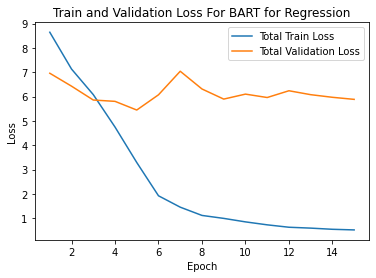

In [16]:
plt.plot(range(1, 16), df_excel['Train Loss'].tolist(), label='Total Train Loss')
plt.plot(range(1, 16), df_excel['Validation Loss'].tolist(), label='Total Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss For BART for Regression')
plt.legend()
plt.show()

In [35]:
predictions=[]

In [36]:
for sub in df.subtitles:
    inputs = tokenizer(sub, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    with torch.no_grad():
        regression_output = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
        predicted_score = regression_output.item()
    predictions.append(predicted_score)
    

In [37]:
df_predictions=pd.DataFrame({ 'Language_Score':df['Language'].tolist(),"Predcited_Score":predictions})

In [5]:
df_predictions.head()

,Unnamed: 0,Language_Score,Generated_Language_Score
0,0,5,5.210726
1,1,10,8.236761
2,2,5,5.133732
3,3,5,4.616990
4,4,9,7.753266


In [3]:
df_predictions[1803:]

,Unnamed: 0,Language_Score,Generated_Language_Score
1803,1803,6,7.661299
1804,1804,7,4.607816
1805,1805,7,4.454864
1806,1806,9,7.200356
1807,1807,1,5.119037
...,...,...,...
1999,1999,1,7.409991
2000,2000,1,6.262559
2001,2001,6,6.096935
2002,2002,6,6.214080


In [8]:
import numpy as np

In [4]:
df_predictions=pd.read_excel('../predictions_BartForRegression.xlsx')

In [5]:
df_predictions

,Unnamed: 0,Language_Score,Predcited_Score
0,0,5,5.582466
1,1,10,10.517991
2,2,5,5.170567
3,3,5,5.419154
4,4,9,7.819332
...,...,...,...
1999,1999,1,1.017422
2000,2000,1,1.298275
2001,2001,6,5.550373
2002,2002,6,6.657488


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

true_labels=np.array(df_predictions['Language_Score'].tolist())
predicted_scores=np.array(df_predictions['Predcited_Score'].tolist())
mse = mean_squared_error(true_labels[1803:], predicted_scores[1803:])
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_labels, predicted_scores)
r2 = r2_score(true_labels, predicted_scores)
evs = explained_variance_score(true_labels, predicted_scores)

In [11]:
print("mse: ",mse)
print("rmse: ",rmse)
print("mae: ",mae)
print("r2: ",r2)
print("evs: ",evs)

mse:  1.8038604974228398
rmse:  1.3430787383555887
mae:  0.5848266576805307
r2:  0.8662430136720121
evs:  0.8698529514030195
